In [65]:
import matplotlib.pyplot as plt
from rs_datasets import MovieLens
ds = MovieLens(version='100k')

In [66]:
def plot_interactions_histogram(data_frame):
    data_frame.groupby('user_id').size().hist(bins=50)
    plt.title('Histogram of interactions per user')
    plt.xlabel('Number of interactions')
    plt.ylabel('Number of movies')
    plt.show()

In [67]:
df = ds.ratings

In [68]:
df.max()

user_id            943
item_id           1682
rating               5
timestamp    893286638
dtype: int32

In [69]:
df.min()

user_id              1
item_id              1
rating               1
timestamp    874724710
dtype: int32

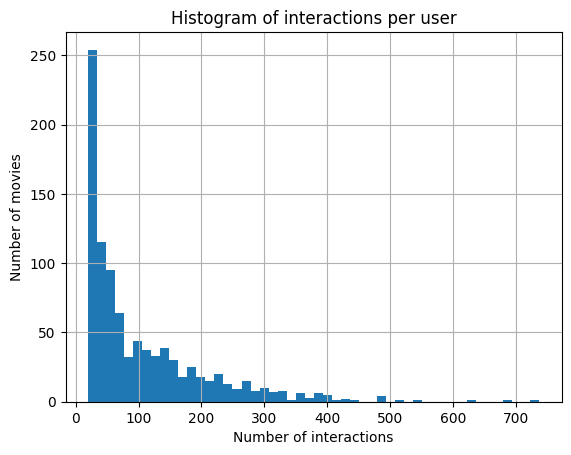

In [70]:
plot_interactions_histogram(df)

In [177]:
# Группируем по userId и фильтруем
filtered_users = df.groupby('user_id').filter(lambda x: len(x) >= 100)[:10000]

# Переиндексация колонки
filtered_users['user_id'] = filtered_users['user_id'].rank(method='dense').astype(int)
# Переиндексация колонки
filtered_users['item_id'] = filtered_users['item_id'].rank(method='dense').astype(int)

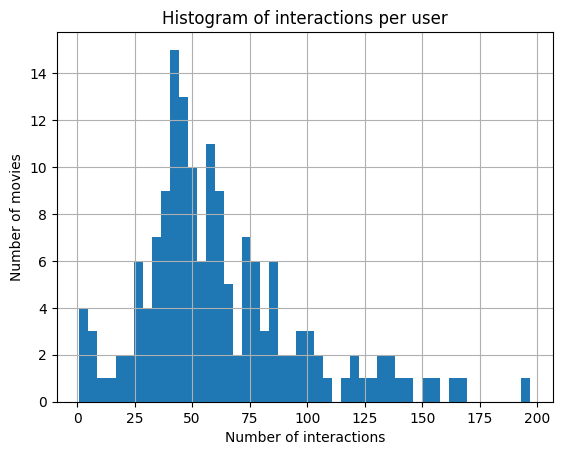

In [178]:
plot_interactions_histogram(filtered_users)

In [179]:
sorted_df = filtered_users.sort_values(by='timestamp')



In [180]:
from sklearn.model_selection import train_test_split

train_df, test_df = train_test_split(sorted_df, test_size=0.2, random_state=42)


In [181]:
import matplotlib.pyplot as plt

def user_history(user_id, data_frame):
    return data_frame[data_frame['user_id'] == user_id]

def plot_user_interactions(user_id, data_frame):
    user_data = user_history(user_id, data_frame)
  #  user_data.groupby('item_id').size().plot(kind='bar')
    plt.bar(user_data['item_id'], user_data['rating'])
    plt.title(f'Interactions for user {user_id}')
    plt.xlabel('Movie ID')
    plt.ylabel('Rating')
    plt.show()


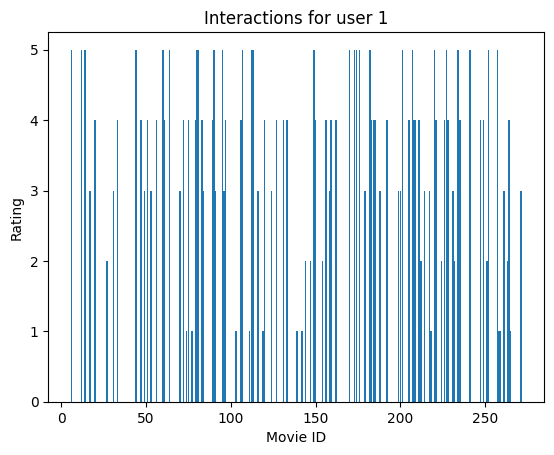

In [184]:

plot_user_interactions(1, sorted_df)

In [185]:
from sklearn.neighbors import NearestNeighbors

# Обучение модели на основе интеракций пользователя
def train_knn(data_frame, n_neighbors=5):
    user_item_matrix = data_frame.pivot(index='user_id', columns='item_id', values='rating').fillna(0)
    model_knn = NearestNeighbors(metric='cosine', algorithm='brute', n_neighbors=n_neighbors)
    model_knn.fit(user_item_matrix)
    return model_knn, user_item_matrix

# Получение рекомендаций для определенного пользователя
def get_recommendations(user_id, model_knn, user_item_matrix):
    distances, indices = model_knn.kneighbors(user_item_matrix.loc[user_id].values.reshape(1, -1))
    closest_users = user_item_matrix.index[indices.flatten()]
    recommended_movies = user_item_matrix.loc[closest_users].mean().sort_values(ascending=False).index
    return recommended_movies


In [186]:
model, matrix = train_knn(train_df)

In [187]:
recs = get_recommendations(1, model, matrix)

In [188]:
recs

Int64Index([ 228,   64,  173,   90,   14,   80,  515,  232,   70,  192,
            ...
             589,  143,  591,  594,  595,  596,  597,  598,  599, 1285],
           dtype='int64', name='item_id', length=1229)

In [242]:
import numpy as np
import pandas as pd

# Функция для вычисления косинусного расстояния
def cosine_similarity(vec_a, vec_b):
    dot_product = np.dot(vec_a, vec_b)
    norm_a = np.linalg.norm(vec_a)
    norm_b = np.linalg.norm(vec_b)
    return dot_product / (norm_a * norm_b)

# KNN реализация
def knn_recommendations(user_id, data_frame, k=5):
    user_item_matrix = data_frame.pivot(index='user_id', columns='item_id', values='rating').fillna(0)
    
    target_user_vector = user_item_matrix.loc[user_id].values
    
    # Вычисление косинусного расстояния от целевого пользователя до всех остальных
    similarities = {}
    for user, row in user_item_matrix.iterrows():
        if user != user_id:
            similarity = cosine_similarity(target_user_vector, row.values)
            similarities[user] = similarity
    
    # Сортировка пользователей по косинусному расстоянию
    sorted_users = sorted(similarities, key=similarities.get, reverse=True)
    
    # Выборка k ближайших пользователей
    nearest_users = sorted_users[:k]
   # print(nearest_users)
    # Получение рекомендаций на основе предпочтений этих пользователей
    recommended_movies = user_item_matrix.loc[nearest_users].mean().sort_values(ascending=False).index
    
    # Уберите фильмы, которые уже были просмотрены целевым пользователем
    #watched_movies = set(data_frame[data_frame['user_id'] == user_id]['item_id'])
    #recommendations = [movie for movie in recommended_movies if movie not in watched_movies]
    
    return recommended_movies


In [247]:
def precision_at_k(predictions, true_items, k):
    relevant_items = set(true_items)
    top_k_items = predictions[:k]
    num_relevant = sum([1 for item in top_k_items if item in relevant_items])
    return num_relevant / k

def recall_at_k(predictions, true_items, k):
    relevant_items = set(true_items)
    top_k_items = predictions[:k]
    num_relevant = sum([1 for item in top_k_items if item in relevant_items])
    
    return num_relevant / len(relevant_items)

# Оценка качества KNN
def evaluate_knn(user_id, train_df, test_df, top_k = 10, k_neighbours = 5):
    true_items = test_df[test_df['user_id'] == user_id]['item_id'].tolist()
   # print(true_items)
    recommendations = knn_recommendations(user_id, train_df, k=k_neighbours)
   # print("+++++")
   ## print(recommendations[:k])
    prec_at_k = precision_at_k(recommendations, true_items, top_k)
    rec_at_k = recall_at_k(recommendations, true_items, top_k)
    
    return prec_at_k, rec_at_k


In [248]:
def average_precision_and_recall(train_df, test_df, top_k = 10, k_neighbours = 5):
    all_users = test_df['user_id'].unique()
    
    total_precision = 0
    total_recall = 0
    num_users = 0
    
    for user_id in all_users:
        try:
            prec_at_k, rec_at_k = evaluate_knn(user_id, train_df, test_df, top_k, k_neighbours)
            total_precision += prec_at_k
            total_recall += rec_at_k
            num_users += 1
        except Exception as e:
            print(e)
            continue  # Это может быть полезно, если для каких-то пользователей нет рекомендаций или истинных элементов
    
    avg_precision = total_precision / num_users
    avg_recall = total_recall / num_users
    
    return avg_precision, avg_recall

# Предположим, что у вас есть разделенные наборы данных train_df и test_df:
# avg_prec, avg_rec = average_precision_and_recall(train_df, test_df)
# print(f"Average Precision@K: {avg_prec:.4f}")
# print(f"Average Recall@K: {avg_rec:.4f}")


In [258]:
precission, recall = average_precision_and_recall(train_df, train_df, top_k = 10, k_neighbours = 5)

In [259]:
print(f"Average Precision@K: {precission:.4f}")
print(f"Average Recall@K: {recall:.4f}")


Average Precision@K: 0.4292
Average Recall@K: 0.1243


In [257]:
from sklearn.neighbors import NearestNeighbors

def train_knn(data_frame, n_neighbors=5):
    user_item_matrix = data_frame.pivot(index='user_id', columns='item_id', values='rating').fillna(0)
    model_knn = NearestNeighbors(metric='cosine', algorithm='brute', n_neighbors=n_neighbors + 1)  # +1 чтобы убрать самого пользователя из списка соседей
    model_knn.fit(user_item_matrix)
    return model_knn, user_item_matrix

def get_recommendations(user_id, model_knn, user_item_matrix):
    distances, indices = model_knn.kneighbors(user_item_matrix.loc[user_id].values.reshape(1, -1))
    closest_users = user_item_matrix.index[indices.flatten()]
    recommended_movies = user_item_matrix.loc[closest_users].mean().sort_values(ascending=False).index
    return recommended_movies

# Функции оценки
def precision_at_k(predictions, true_items, k):
    top_k_items = predictions[:k]
    num_relevant = sum([1 for item in top_k_items if item in true_items])
    return num_relevant / k

def recall_at_k(predictions, true_items, k):
    top_k_items = predictions[:k]
    num_relevant = sum([1 for item in top_k_items if item in true_items])
    return num_relevant / len(true_items)

def evaluate_for_user(user_id, model_knn, user_item_matrix, test_df, k=5):
    recommendations = get_recommendations(user_id, model_knn, user_item_matrix)
    true_items = test_df[test_df['user_id'] == user_id]['item_id'].tolist()
    
    prec_at_k = precision_at_k(recommendations, true_items, 10)
    rec_at_k = recall_at_k(recommendations, true_items, 10)
    
    return prec_at_k, rec_at_k

def average_precision_and_recall_for_all(model_knn, user_item_matrix, test_df, k=10):
    all_users = test_df['user_id'].unique()
    
    total_precision = 0
    total_recall = 0
    num_users = 0
    
    for user_id in all_users:
        try:
            prec_at_k, rec_at_k = evaluate_for_user(user_id, model_knn, user_item_matrix, test_df, k)
            total_precision += prec_at_k
            total_recall += rec_at_k
            num_users += 1
        except:
            continue
    
    avg_precision = total_precision / num_users
    avg_recall = total_recall / num_users
    
    return avg_precision, avg_recall

# Используйте эти функции, предполагая, что у вас уже есть train_df и test_df
model, user_item_matrix = train_knn(train_df)
avg_prec, avg_rec = average_precision_and_recall_for_all(model, user_item_matrix, train_df)
print(f"Average Precision@K: {avg_prec:.4f}")
print(f"Average Recall@K: {avg_rec:.4f}")


Average Precision@K: 0.7466
Average Recall@K: 0.2011
